<p style="font-size: 46pt; margin-bottom: 1em; margin-top: 1em;">Many-body tensor representation</p>
<p style="font-size: 18pt; line-height: 120%; margin-bottom: 1em;">Experiments from Haoyan Huo and Matthias Rupp: Unified Representation for Machine Learning of Molecules and Crystals, 2017.</p>

# Initialization

Loading of Python libraries and <tt>qmmlpack</tt>.

In [14]:
# import libraries
import sys, os
import re, zipfile, json, math, gc
import ast, itertools, hashlib, gzip, pickle
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator
import IPython
from collections import defaultdict

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

np.set_printoptions(linewidth=90)

# load repository version of qmmlpack, not system-wide version
# adapt path according to local installation, or comment out if qmmlpack is available on a system-wide path
sys.path.insert(0, os.path.join(
    os.path.realpath('.'),
    '../qmmlpack/python'))
import qmmlpack as qmml

Code used throughout notebook.

In [15]:
def cached(max_entries=sys.maxsize):
    """Memoization decorator.
    
    Allows caching of function values for representation and kernel functions.
    
    A maximum number of results to be stored can be specified via max_entries.
    
    functools.lru_cache does not accept mutable objects such as NumPy's ndarray.
    
    Caching the functions directly (as opposed to automatic caching within code for experiments) 
    allows caching over multiple experiments."""
    return lambda f: _cached(f, max_entries=max_entries)

class _cached:
    """Implementation of memoization decorator."""
    
    def __init__(self, f, max_entries=sys.maxsize):
        """Wraps f in a caching wrapper."""
        self.f = f  # cached function
        self.max_entries = max_entries  # maximum number of results to store
        self.cache = {}  # stores pairs of hash keys and function results 
        self.lruc = 0  # least recently used counter
        self.hashf = None  # hashing function, initialized by __call__
        self._intbuf = np.empty((1,), dtype=int)  # buffer for temporary storage of hash() values
        self.hits, self.misses = 0, 0  # number of times function values were retrieved from cache/had to be computed 
        self.total_hits, self.total_misses = 0, 0  # statistics over lifetime of cached object
        
    def _hash(self, arg):
        """Hashes an argument."""
        try:
            self.hashf.update(arg)
        except:
            self._intbuf[0] = hash(arg)
            self.hashf.update(self._intbuf)
        
    def __call__(self, *args, **kwargs):
        """Calls to cached function."""
        
        # compute hash key of arguments
        self.hashf = hashlib.md5()  # non-cryptographic fast hash function
        for i in args: self._hash(i)
        for i in kwargs: self._hash(kwargs[i])
        key = self.hashf.digest()
        
        # return stored or computed value
        if key in self.cache:
            self.total_hits, self.hits = self.total_hits + 1, self.hits + 1
            item = self.cache[key]
            item[0] = self.lruc; self.lruc += 1
            return item[1]
        else:
            self.total_misses, self.misses = self.total_misses + 1, self.misses + 1
            value = self.f(*args, **kwargs)
            self.cache[key] = [self.lruc, value]; self.lruc += 1

            # remove another entry if new entry exceeded the maximum
            if len(self.cache) > self.max_entries:
                c, k = self.lruc, key
                for k_,v_ in self.cache.items():
                    if v_[0] < c: c, k = v_[0], k_
                del self.cache[k]
            
            return value
        
    def clear_cache(self):
        """Empties cache, releasing memory."""
        self.cache.clear()
        self.hits, self.misses = 0, 0

In [16]:
from qmmlpack.lib import is_sequence, QMMLException

class AdaptiveGridSearch:
    """Optimization of several variables via local gradient descent on a logarithmic grid.

    Interface:
      __init__ - sets up adaptive grid search
      step() - takes one optimization step
      stats() - returns statistics on optimization so far"""

    def _parse_variable(self, v):
        """Parses one variable.

        0  initial value
        1  priority
        2  step size
        3  min
        4  max
        5  direction
        6  base"""

        defaults = (0., 1, 1., -np.inf, +np.inf, 0, 2.)
        keywords = ((0,'value'), (1,'priority'), (2,'stepsize'), (3,'min'), (3,'minimum'), (4,'max'), (4,'maximum'), (5,'direction'), (6,'base'))

        # dictionary specification
        if isinstance(v, dict):
            vv = list(defaults)
            for (i,kw) in keywords:
                if kw in v: vv[i] = v[kw]
            v = vv

        if not is_sequence(v): raise QMMLException("Invalid variable specification")

        # initial value
        iv = defaults[0] if len(v) < 1 else float(v[0])

        # priority
        p = defaults[1] if len(v) < 2 else int(v[1])
        if len(v) >= 2 and p != v[1]: raise QMMLException("Non-integer priority specified")
        if p <= 0: raise QMMLException("Invalid priority specified")

        # step size
        s = defaults[2] if len(v) < 3 else float(v[2])
        if s <= 0: raise QMMLException("Invalid step size specified")

        # minimum
        rmin = defaults[3] if len(v) < 4 else v[3]

        # maximum
        rmax = default[4] if len(v) < 5 else v[4]

        # direction
        d = defaults[5] if len(v) < 6 else int(v[5])
        if len(v) >= 6 and d != v[5]: raise QMMLException("Non-integer direction specified")
        if d not in (-1, 0, +1): raise QMMLException("Invalid direction specified")

        # base
        b = defaults[6] if len(v) < 7 else float(v[6])
        if b <= 0: raise QMMLException("Invalid base specified")

        # additional tests
        if rmin >= rmax: raise QMMLException("Invalid range specified")
        if not (rmin <= iv <= rmax): raise QMMLException("Initial value not in range")

        return [iv, p, s, rmin, rmax, d, b]

    def __init__(self, f, variables, resolution=None):
        """AdaptiveGridSearch(f, {v1,v2,...}, resolution=None) finds local minimum of f(v1,v2,...) via local gradient descent on a logarithmic grid.

        Parameters:
          f - function to be minimized
          v1,v2,... - variables, see below
          resolution - if specified as a number a, f(...) will be rounded to multiples of a

        A variable is a tuple {val, pri, stp, min, max, dir, b}, where
          val = initial value; real number; exponent to base b
          pri = priority; positive integer; higher priorities are optimized before lower ones; several variables may have the same priority
          stp = step size; positive real number; refers to exponent
          min = lowest allowed value for variable, val in [min,max]
          max = highest allowed value for variable, val in [min,max]
          dir = direction; either -1 (small values preferred), 0 (indifferent), +1 (large values preferred)
          b   = base; positive real number
          Later entries can be omitted. Default values are (0., 1, 1., (-np.inf,+np.inf), 0, 2., (True,True)).
          The logarithmized grid is the intersection between ...,i-2s,i-s,i,i+s,i+2s,... and (min,max).
          Alternatively, a dictionary with possible keys 'value', 'priority', 'stepsize', 'min', 'max', 'direction', 'base' can be specified.

        Once the grid search is initialized, optimization steps can be taken via step().
        Data member stats yields statistics on the optimization so far.

        If optimizing an expensive function, such as hyperparameters of a machine learning model, it is important that f uses cached values.
        For example, if optimizing performance of a kernel learning model, kernel matrices for different values of kernel hyperparameters should be cached where possible."""

        # the descent can not cross itself, but a visited list helps avoid retrying unsuccessful grid points, reducing number of steps.

        # initialize state
        self._vars = np.asarray([self._parse_variable(v) for v in variables])
        self._f = f
        self._resolution = None if resolution is None else float(resolution)

        self.num_vars = len(self._vars)
        self.num_steps = 0
        self.num_evals = 0
        self.update = False
        self.done = False
        self.conv = [False] * len(self._vars)  # indicates which variables to optimize; True entries are currently converged
        self.dirs = [np.random.choice([-1,1]) if v[5] == 0 else int(v[5]) for v in self._vars]
        self.cur_ind = 0  # index of variable currently being iterated
        self.cur_v = np.copy(self._vars[:, 0])  # current values of variables
        self.trial_v = np.empty_like(self.cur_v)  # last tried values of variables
        self.trial_f = None  # f of last tried values of variables
        self.best_v = np.copy(self.cur_v)  # best solution so far
        self.best_f = np.inf;  # f of best solution so far, f(best_v)
        self.visited = set()  # visited grid points so far

        # initialize optimization
        self._trial(0.)
        self.update = False  # force determination of cur_ind

    def _trial(self, step):
        ind = self.cur_ind  # shorthand
        self.update = False

        # take step
        self.trial_v[:] = self.cur_v
        self.trial_v[ind] += step

        # check for range (clamping incurs some unnecessary calls of f, but allows variable to change direction)
        self.trial_v[ind] = max(self._vars[ind,3], min(self.trial_v[ind], self._vars[ind, 4]))  # clamp to [min, max]

        # check if visited already
        if tuple(self.trial_v) in self.visited: return

        # call f
        trialpowers = np.power(self._vars[:, 6], self.trial_v)
        self.trial_f = self._f(*trialpowers)
        self.num_evals += 1
        self.visited.add(tuple(self.trial_v))
        if self._resolution is not None:
            # rounds to precision of resolution, then to number of significant digits to avoid trailing noise in last digits
            # https://stackoverflow.com/a/28427814/3248771
            self.trial_f = round( round(self.trial_f / self._resolution) * self._resolution, -int(math.floor(math.log10(self._resolution))))

        # update if improvement
        if self.trial_f < self.best_f:
            self.cur_v[:] = self.trial_v
            self.best_v[:] = self.trial_v
            self.best_f = self.trial_f
            self.update = True
            self.conv = [False] * self.num_vars

    def step(self):
        """Takes one optimization step.

        The step taken can involve multiple evaluations of f."""

        if self.done: return

        # determine variable to optimize next
        if not self.update:
            self.cur_ind = [i for (i,d) in enumerate(self.conv) if not d]  # variables currently being optimized
            self.cur_ind = [i for i in self.cur_ind if self._vars[i,1] == max(self._vars[self.cur_ind, 1])]  # variables with highest priority
            self.cur_ind = np.random.choice(self.cur_ind)

        # take one step into direction
        if self._vars[self.cur_ind, 5] in (-1,+1):
            self.dirs[self.cur_ind] = int(self._vars[self.cur_ind, 5])  # if not, keep last direction
        self._trial(self.dirs[self.cur_ind] * self._vars[self.cur_ind, 2])

        # change direction if unsuccessful
        if not self.update:
            self.dirs[self.cur_ind] *= -1
            self._trial(self.dirs[self.cur_ind] * self._vars[self.cur_ind, 2])

        # if no update, variable is converged
        if not self.update:
            self.conv[self.cur_ind] = True

        # update statistics
        self.num_steps += 1

        # test termination condition
        if all(self.conv): self.done = True

    def __bool__(self):
        """Indicates whether optimization is ongoing or done."""
        return not self.done

    def __str__(self, verbose=False):
        """Returns formatted statistics."""
        s = self.stats()
        if verbose == 'compact':
            descr = \
                "#{}({}): {} -> {}  ({})".format(s['num_steps'], s['num_evals'], tuple(s['best_vals']), \
                s['best_f'], ''.join(["T " if c else "F " for c in s['converged']]) )
        else:
            descr = \
                "{}\n\n".format(self.__class__.__name__) + \
                "#vars = {}, #steps = {}, #evals = {}, done = {}\n".format(s['num_vars'], s['num_steps'], s['num_evals'], s['done']) + \
                "best solution: f{} = {}\n".format(tuple(s['best_vals']), s['best_f']) + \
                "var = {}, update = {}\n".format(s['cur_var'], s['update']) + \
                "converged vars: {}, ".format(' '.join(["T " if c else "F " for c in s['converged']])) + \
                "directions: {}\n".format(' '.join(['{:+d}'.format(d) for d in s['directions']])) + \
                ( "" if not verbose else "\nvisited:\n{}".format(''.join(sorted(['  {}\n'.format(v) for v in s['visited']]))) )
        return descr

    def stats(self):
        """Returns dictionary with statistics on the course of the optimization so far.

          variables - variables settings
          resolution - resolution
          num_vars - number of variables (arity of f)
          num_steps - number of times step() was called
          num_evals - number of times f was evaluated
          update - whether best solution was updated last step
          done - True if optimization is finished
          converged - which variables are currently in local minima
          directions - current directions of variables
          cur_var - index of currently optimized variable
          cur_vals - current values of variables
          trial_vals - last tried values of variables
          trial_f - function value for trial_vals
          best_vals - best found variable values so far
          best_f - function value for best_vals
          visited - set of variable values visited so far
        """

        return {
            'variables' : self._vars,
            'resolution': self._resolution,
            'num_vars'  : self.num_vars,
            'num_steps' : self.num_steps,
            'num_evals' : self.num_evals,
            'update'    : self.update,
            'done'      : self.done,
            'converged' : self.conv,
            'directions': self.dirs,
            'cur_var'   : self.cur_ind,
            'cur_vals'  : self.cur_v,
            'trial_vals': self.trial_v,
            'trial_f'   : self.trial_f,
            'best_vals' : self.best_v,
            'best_f'    : self.best_f,
            'visited'   : self.visited
        }

In [17]:
class EvaluateModelPerformance:
    """Performance of a kernel ridge regression model.
    
    Returns loss of kernel regression model on validation set using given hyperparameters.
    Implemented as a stateful functor."""
    
    def __init__(self, z, r, y, indtrain, indvalid, reprf, kernelf, lossf, paramf, basis=None, centering=False, maxcache=False):
        """Sets up model performance evaluator.
        
        z, r, y, basis - atomic numbers, atom coordinates, property values and basis vectors
        indtrain, indvalid - indices into z, r, y, basis of training and validation sets
        reprf - function f(z, r, basis, theta) returning n x d representation matrix, where 
                n is number of data points and d is dimensionality of representation; can be a list of functions
        kernelf - kernel function
        lossf - loss function f(true, pred, state, z) returning a single summary statistic of the performance
        paramf - function accepting one parameter vector theta, which it splits into 
            individual parameter vectors for representation, kernel and method.
        centering - whether to center the kernelf
        maxcache - if True, reprf and kernelf will always be called for the whole input, 
                   maximixing cache exploitation across large series of experiments such as learning curves.
        
        If reprf is a list, representations are cached separately and concatenated.
        
        The employed representation and kernel functions should cache (memoize) their values.
        This caching is best done outside of this class by the actual functions to maximize speed gains across
        different instances of EvaluateModelPerformance."""

        # parameters
        self.z, self.r, self.y, self.indtrain, self.indvalid, self.reprf, self.kernelf, self.lossf, self.paramf, \
            self.b, self.centering, self.maxcache = z, r, y, indtrain, indvalid, reprf, kernelf, lossf, paramf, \
            basis, centering, maxcache
        if not qmml.is_sequence(self.reprf): self.reprf = (self.reprf,)  # always a sequence
        
    def reset(self, z=None, r=None, y=None, indtrain=None, indvalid=None, reprf=None, kernelf=None, lossf=None, \
              paramf=None, basis=None, centering=None, maxcache=None):
        """Modifies parametrization."""

        if z is not None: self.z = z
        if r is not None: self.r = r
        if y is not None: self.y = y
        if indtrain is not None: self.indtrain = indtrain
        if indvalid is not None: self.indvalid = indvalid
        if reprf is not None: self.reprf = reprf  # sequence will be ensured by __init__ below
        if kernelf is not None: self.kernelf = kernelf
        if lossf is not None: self.lossf = lossf
        if paramf is not None: self.paramf = paramf
        if basis is not None: self.b = basis
        if centering is not None: self.centering = centering
        if maxcache is not None: self.maxcache = maxcache

        self.__init__(self.z, self.r, self.y, self.indtrain, self.indvalid, self.reprf, self.kernelf, self.lossf, \
                      self.paramf, basis=self.b, centering=self.centering, maxcache=self.maxcache)

    def __call__(self, *theta):
        """Evaluates model performance for given hyperparameters theta."""

        # parameter vectors
        (theta_repr, theta_kernel, theta_method) = self.paramf(*theta)
        if len(theta_repr) == 0 or not qmml.is_sequence(theta_repr[0]): theta_repr = [theta_repr]
        theta_repr = tuple(tuple(theta) for theta in theta_repr)
        theta_kernel, theta_method = tuple(theta_kernel), tuple(theta_method)
        
        # representation and kernel matrices
        if self.maxcache:  # call reprf and kernelf for all inputs
            # representation
            repr_ = [rf(self.z, self.r, basis=self.b, theta=rt) for (rf,rt) in zip(self.reprf, theta_repr)]
            repr_ = np.concatenate(repr_, axis=1)
            # kernel matrix
            M = self.kernelf(repr_, theta=theta_kernel)
            # reduce to training and test sets
            reprtrain, reprvalid = repr_[self.indtrain], repr_[self.indvalid]
            K, L = M[np.ix_(self.indtrain, self.indtrain)], M[np.ix_(self.indtrain, self.indvalid)]
        else:  # call reprf and kernelf only for training and validation sets
            # representation
            (btrain, bvalid) = (None, None) if self.b is None else (self.b[self.indtrain], self.b[self.indvalid])
            reprtrain = [rf(self.z[self.indtrain], self.r[self.indtrain], basis=btrain, theta=rt) for (rf,rt) in zip(self.reprf, theta_repr)]
            reprvalid = [rf(self.z[self.indvalid], self.r[self.indvalid], basis=bvalid, theta=rt) for (rf,rt) in zip(self.reprf, theta_repr)]
            reprtrain, reprvalid = np.concatenate(reprtrain, axis=1), np.concatenate(reprvalid, axis=1)
            # kernel matrices
            K = self.kernelf(reprtrain, theta=theta_kernel)
            L = self.kernelf(reprtrain, reprvalid, theta=theta_kernel)
   
        # model and predictions
        krr = qmml.KernelRidgeRegression(K, self.y[self.indtrain], theta_method, centering=self.centering)
        pred = krr(L)

        # loss
        self.loss = lambda: None  # dummy object for storing additional data computed by lossf
        loss = self.lossf(self.y[self.indvalid], pred, state=self.loss, z=self.z[self.indvalid])
        return loss

In [18]:
def setup_train_valid(ind, ntrain, nvalid, y=None):
    """Sets up training and validation folds (index subsets) for model selection.
    
    Data indices are split into disjunct training and validation set.
    If labels are given, training and validation sets are stratified to reduce variance."""
    
    ind = np.asarray(ind, dtype=int)
    
    n = len(ind)
    assert ntrain + nvalid <= n
    assert y is None or len(y) == n
    
    # validation set
    if y is None: # random sampling
        indvalid = np.random.choice(ind, size=nvalid, replace=False)
    else:  # stratified sampling
        indvalid = ind[ [np.random.choice(stratum) for stratum in qmml.stratify(y, nvalid)] ]
    
    # training set
    indrem = np.nonzero(np.in1d(ind, indvalid, invert=True))[0]  # remaining indices not in indvalid
    if y is None: # random sampling
        indtrain = np.random.choice(ind[indrem], size=ntrain, replace=False)
    else:  # stratified sampling
        indtrain = ind[indrem][ [np.random.choice(stratum) for stratum in qmml.stratify(y[indrem], ntrain)] ]
    
    # verify
    assert indtrain.size == ntrain and indvalid.size == nvalid
    assert np.intersect1d(indtrain, indvalid).size == 0
    
    return (indtrain, indvalid)

In [19]:
def lossf(true, pred, state=None, z=None, return_='root_mean_squared_error'):
    """Augmented loss function.
    
    Parameters:
      true - reference labels
      pred - predicted labels
      state - if passed, reference values, predictions, residuals and loss function values will be
              stored as true, pred, residuals, loss. If z is passed, sizes and residuals_pa as well.
      z - atomic numbers; if passed, loss per atom will be computed in addition
      return_ - name of summary statistic to return."""

    residuals = np.asfarray(pred - true)
    loss = qmml.loss(true, pred)
    
    # if available, compute loss functions normalized by number of atoms
    if z is not None:
        assert len(z) == len(residuals)
        
        sizes = np.asarray([len(m) for m in z])  # number of atoms per system
        residuals_pa = residuals / sizes

        rmsepa = math.sqrt(np.mean(residuals_pa**2)) # RMSE per atom
        loss['root_mean_squared_error_per_atom'] = rmsepa
        
        maepa = np.mean(np.abs(residuals_pa))  # MAE per atom
        loss['mean_absolute_error_per_atom'] = maepa
        
        maxaepa = max(np.abs(residuals_pa))  # maxAE per atom
        loss['maximum_absolute_error_per_atom'] = maxaepa
    
    # if state is available, store statistics
    if state is not None:
        state.true, state.pred, state.residuals, state.loss = true, pred, residuals, loss
        if z is not None:
            state.sizes, state.residuals_pa = sizes, residuals_pa

    # quantity to return
    return loss[return_]

In [20]:
def pretty_print_loss(loss, digits=2, addloss=None):
    """Formats loss function values as a human-readable string.
    
    Parameters:
      loss - result of loss function
      digits - number of digits after decimal point
      addloss - additional summary statistics to print (if contained in loss)
                list of 2-tuples (long name, abbreviation)"""
    
    if addloss is None: 
        addloss = [ 
            ('root_mean_squared_error_per_atom', 'RMSE/a '), \
            ('mean_absolute_error_per_atom'    , 'MAE/a  '), 
            ('maximum_absolute_error_per_atom' , 'maxAE/a')]
    res = \
        'n       = {}\n'      .format(loss['number_of_samples'])               + \
        'RMSE    = {:0.{}f}\n'.format(loss['root_mean_squared_error'], digits) + \
        'MAE     = {:0.{}f}\n'.format(loss['mean_absolute_error'], digits)     + \
        'R^2     = {:0.6f}\n' .format(loss['correlation_squared'])             + \
        'maxAE   = {:0.{}f}\n'.format(loss['maximum_absolute_error'], digits)
        
    for al in addloss: 
        if al[0] in loss: res += '{} = {:0.{}f}\n'.format(al[1], loss[al[0]], digits)

    return res

In [21]:
def dataset_info(z, r, e, basis=None, verbose=None):
    """Information about a dataset.
    
    Returns a dictionary containing information about a dataset.
    
    Parameters:
      z - atomic numbers
      r - atom coordinates, in Angstrom
      e - energies
      basis - basis vectors for periodic systems
      verbose - if True, also prints the information
    
    Information:
      elements - elements occurring in dataset
      max_elements_per_system - largest number of different elements in a system
      max_same_element_per_system - largest number of same-element atoms in a system
      max_atoms_per_system - largest number of atoms in a system
      min_distance - minimum distance between atoms in a system
      max_distance - maximum distance between atoms in a system    
    """
    assert len(z) == len(r) == len(e)
    assert basis is None or len(basis) == len(z)

    i = {}
    
    i['number_systems'] = len(z)
    
    # elements
    i['elements'] = np.unique(np.asarray([a for s in z for a in s], dtype=int)) 
    i['max_elements_per_system'] = max([np.nonzero(np.bincount(s.astype(int)))[0].size for s in z])
    i['max_same_element_per_system'] = max([max(np.bincount(s.astype(int))) for s in z]) 
    
    # systems
    i['max_atoms_per_system'] = max([len(s) for s in z])
    i['systems_per_element'] = np.asarray([np.sum([1 for m in z if el in m]) for el in range(118)], dtype=int)
    
    # distances
    assert len(r) > 0
    dists = [qmml.lower_triangular_part(qmml.distance_euclidean(rr), -1) for rr in r]
    i['min_distance'] = min([min(d) for d in dists if len(d) > 0])
    i['max_distance'] = max([max(d) for d in dists if len(d) > 0])
    
    # verbose output
    if verbose:
        if basis is None: print('{} finite systems (molecules)'.format(i['number_systems']))
        else: print( '{} periodic systems (materials)'.format(i['number_systems']) )    
        print('elements: {} ({})'.format(' '.join([qmml.element_data(el, 'abbreviation') \
            for el in i['elements']]), len(i['elements'])))
        print('max #els/system: {};  max #el/system: {};  max #atoms/system: {}'.format( \
            i['max_elements_per_system'], i['max_same_element_per_system'], i['max_atoms_per_system']))
        print('min dist: {:3.2f};  max dist: {:3.2f};  1/min dist: {:3.2f};  1/max dist: {:3.2f}'.format( \
            i['min_distance'], i['max_distance'], 1./i['min_distance'], 1./i['max_distance']))
        
    return i

In [22]:
def import_dataset_xyz(zipfn, datafn, addpts=False, ysplitchrs=';\[|\],\[|,|\[|\]| ', n=None):
    """Loads dataset in (extended) xyz format.
    
    Parameters:
      zipfn - name of compressed archive file
      datafn - name of file in extended xyz format
      addpts - whether systems contain additional property lines
      ysplitchrs - characters at which to split the property line as regular expression
      n - number of expected systems"""
    
    # load raw data
    with zipfile.ZipFile(zipfn, 'r') as zf:
        raw = zf.read(datafn).decode('ascii')
        
    # parse XYZ format
    xyzdata = qmml.import_extxyz(raw, additional_properties=addpts)
    
    # extract information
    z = np.asarray([m.an for m in xyzdata], dtype=object)
    r = np.asarray([m.xyz for m in xyzdata], dtype=object)
    parsef = lambda s: [float(ss) for ss in re.split(ysplitchrs, s) if ss != ''] if isinstance(s, str) else s
    y = np.asarray([[parsef(mp) for mp in m.mp] for m in xyzdata])
    if len(y.shape) == 3 and y.shape[1] == 1: y = y[:,0,:]
    elems = np.unique([el for m in z for el in m]) # element species universe

    if n is not None and (n != len(z) or n != len(r) or n != len(y)): 
        raise RuntimeError('unexpected number of systems')
    
    return (z, r, y, elems, len(z))

In [23]:
def import_dataset_json(zipfn, datafn, ctrl, n=None):
    """Imports a dataset in the format of the elpasolite dataset.
    
    Parameters:
      zipfn, datafn - filenames of ZIP container and compressed data file inside
      ctrl - list of data blocks to parse
      n - expected number of systems
      
    Returns:
      z, r, e, b, sizes, elems, sg, details, n
    """
    
    # load raw data from file
    with zipfile.ZipFile(zipfn, 'r') as zf:
        raw = zf.read(datafn).decode('ascii')
    
    # split into blocks, one for each crystal
    raw = re.split(r'--- \d+ ---\n', raw)[1:]  
    if n is not None and len(raw) != n: raise RuntimeError('Unexpected number of parsed entries.')
        
    # parse content via regular expressions
    tokens = {
        'FE/a'   : r'Formation energy \(eV/atom\):\s*'+ r'(?P<energy>(-?\d+\.\d+))\s*'         ,
        'TE'     : r'Total Energy \(eV/cell\):\s*'    + r'(?P<energy>(-?\d+\.\d+))\s*'         ,
        'FE'     : r'Formation enthalpy \(eV\):\s*'   + r'(?P<energy>(-?\d+\.\d+))\s*'         ,
        'V'      : r'Cell Volume:\s+'                 + r'\d+\.\d+\s+'                         ,
        'R'      : r'Coordinates:\s+'                 + r'(?P<coord>((-?\d+\.\d+\s+){3})+)'    ,
        'B'      : r'Cell:\s+'                        + r'(?P<cell>((-?\d+\.\d+\s+){3})+)'     ,
        'a'      : r'Atoms:\s+'                       + r'(?P<atoms>([a-zA-Z]{1,3}\s+)+)'      ,
        'sg'     : r'Space group:\s+'                 + r'(?P<spacegroup>([A-Za-z0-9\-/]+))\s+',
        'repr'   : r'Representation:\s+'              + r'(\d+\s+\d+\s+)+'                     ,
        'details': r'Calculation Details:\s+'         + r'(?P<details>(.+\n?))'                ,
        'end'    : r'(end\s*)?'
    }        
    grammar = re.compile(''.join([tokens[c] for c in ctrl]), flags=re.ASCII)
    raw = [re.fullmatch(grammar, s) for s in raw]
    assert None not in raw

    # extract information
    z = np.asarray([np.asarray([qmml.element_data(el, 'atomic number') for el in m.group('atoms').split()]) for m in raw])
    sizes = np.asarray([len(m) for m in z], dtype=int)  # number of atoms in each structure
    elems = np.unique([el for m in z for el in m]) # element species universe
    
    e = np.asfarray([float(m.group('energy')) for m in raw])
    if 'FE/a' in ctrl: e = e * sizes  # convert to energy per cell if necessary

    b = np.asarray([np.reshape(np.asarray([float(f) for f in m.group('cell').split()]), (3, 3)) for m in raw])
    r = np.asarray([np.reshape(np.asarray([float(f) for f in m.group('coord').split()]), (-1, 3)) for m in raw])
    r = np.asarray([[r_[0]*b_[0] + r_[1]*b_[1] + r_[2]*b_[2] for r_ in rr] for (b_,rr) in zip(b,r)]) # Cartesian coordinates
    
    sg = [m.group('spacegroup') for m in raw] if 'sg' in ctrl else None
    details = [m.group('details') for m in raw] if 'details' in ctrl else None  # calculation details
    
    n = len(z)

    return (z, r, e, b, sizes, elems, sg, details, n)

In [24]:
def paramf(aa, bb, cc):
    """Parameter splitting function dividing parameters into three blocks of sizes a, b, c.
    
    a, b, c are numbers of parameters.
    a can also be a list of numbers of parameters.
    
    paramf([1,2], 0, 1)(['a', 'b', 'c', 'd']) -> ([('a',), ('b', 'c')], tuple(), ('d',))"""
    def f(a, b, c, *theta):
        if qmml.is_sequence(a):
            # multiple representation functions
            # as we have only need for cases 2 and 3, no need to generalize
            assert len(a) == 2 or len(a) == 3
            resa = [ tuple(theta[:a[0]]), tuple(theta[a[0]:a[0]+a[1]]) ]
            if len(a) == 3: resa.append( tuple(theta[a[0]+a[1]:a[0]+a[1]+a[2]]) )
            a = np.sum(a)
        else:
            # single representation function
            resa = tuple(theta[:a])
        return ( resa, tuple(theta[a:a+b]), tuple(theta[a+b:a+b+c]) )
    return lambda *theta: f(aa, bb, cc, *theta)

# Molecular dynamics -- simple energy model (Table II, right)

## Data and code

Data for this section can be downloaded from the following URL:
    
http://quantum-machine.org/gdml/

In [25]:
!wget -nc http://quantum-machine.org/gdml/data/npz/benzene2017_dft.npz -O datasets/benzene2017_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/uracil_dft.npz -O datasets/uracil_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/naphthalene_dft.npz -O datasets/naphthalene_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/aspirin_dft.npz -O datasets/aspirin_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/salicylic_dft.npz -O datasets/salicylic_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/malonaldehyde_dft.npz -O datasets/malonaldehyde_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/ethanol_dft.npz -O datasets/ethanol_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/toluene_dft.npz -O datasets/toluene_dft.npz
!md5 datasets/benzene2017_dft.npz datasets/uracil_dft.npz datasets/naphthalene_dft.npz datasets/aspirin_dft.npz datasets/salicylic_dft.npz datasets/malonaldehyde_dft.npz datasets/ethanol_dft.npz datasets/toluene_dft.npz

File ‘datasets/benzene2017_dft.npz’ already there; not retrieving.
File ‘datasets/uracil_dft.npz’ already there; not retrieving.
File ‘datasets/naphthalene_dft.npz’ already there; not retrieving.
File ‘datasets/aspirin_dft.npz’ already there; not retrieving.
File ‘datasets/salicylic_dft.npz’ already there; not retrieving.
File ‘datasets/malonaldehyde_dft.npz’ already there; not retrieving.
File ‘datasets/ethanol_dft.npz’ already there; not retrieving.
File ‘datasets/toluene_dft.npz’ already there; not retrieving.
MD5 (datasets/benzene2017_dft.npz) = b4337db977aeee3bb400b4a1f0db4210
MD5 (datasets/uracil_dft.npz) = 4c1a8b2247ae4bda3b83ee6e3bd4b825
MD5 (datasets/naphthalene_dft.npz) = d181a613e91cf4c39125e4e844c3dfa6
MD5 (datasets/aspirin_dft.npz) = 6c3bd18c6450b14ee7dc863547b8f935
MD5 (datasets/salicylic_dft.npz) = 90ccf04fb59cf561b15bb6f1bb08f6f9
MD5 (datasets/malonaldehyde_dft.npz) = 988fd88e46f405e4008b33a304f473bd
MD5 (datasets/ethanol_dft.npz) = 0ce72137ee2f96f303254fc4d97dec2a
MD5 

Number of frames in training and validation sets for all molecules.

In [26]:
md_num_train, md_num_valid = 10000, 2000

The molecular dynamics data is loaded in each experiment separately due to it's large volume of almost 1 GB.

The following Coulomb matrix variant was used in 

> Stefan Chmiela, Alexandre Tkatchenko, Huziel E. Sauceda, Igor Poltavsky, Kristof Schütt, Klaus-Robert Müller:
> Machine Learning of Accurate Energy-Conserving Molecular Force Fields, Science Advances 3(5): e1603015, 2017.
> [DOI](https://doi.org/10.1126/sciadv.1603015)
    
See the supplement for details.

In [27]:
def load_qm_17(npz_fn, n):
    npz_data = np.load(npz_fn)
    r = npz_data['R']
    e = npz_data['E'][:, 0]
    z = np.repeat(npz_data['z'][None], axis=0, repeats=n)
    elems = np.unique(z)

    r = np.array(list(r), dtype=object)
    z = np.array(list(z), dtype=object)

    assert n == r.shape[0] == e.shape[0]
    
    return z, r, e, elems, n

@cached(max_entries=40)
def reprfcm(z, r, basis=None, theta=None, flatten=True):
    """Coulomb matrix variant modified for molecular dynamics data.
    
    No padding, as number of atoms is constant.
    No sorting, as the atom order is always the same.
    Diagonal is not used as it is constant."""
    return qmml.coulomb_matrix(z, r, \
        padding=False, flatten=-1, sort=False, \
        post=lambda cmij, zi, zj, dij, i, j : 1. / dij if i != j else cmij)

A variant of MBTR for molecular dynamics data. 
Each atom is treated as it's own species, effectively enabling per-atom information.

In [180]:
@cached(max_entries=20)
def reprfmd2(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=2, inverse distances, no weighting, parametrization for molecular dynamics"""
    assert basis is None
    dmin, dmax = dsi['min_distance'], dsi['max_distance']
    (dsigma2,) = theta
    zz = np.repeat(np.asarray([np.arange(len(z[0]))+1]), len(z), axis=0)
    return qmml.many_body_tensor(
        zz, r, ( 1.05/dmax-0.05/dmin, (1/dmin-1/dmax)*1.1/30, 30),  # [1/dmax, 1/dmin] plus 5% margin
        (2, '1/distance', 'unity', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=None, flatten=flatten)

@cached(max_entries=20)
def reprfmd3(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=3, angles, no weighting, parametrization for molecular dynamics"""
    assert basis is None
    (dsigma2,) = theta
    zz = np.repeat(np.asarray([np.arange(len(z[0]))+1]), len(z), axis=0)
    return qmml.many_body_tensor(
        zz, r, ( -np.pi*0.05, np.pi*1.1/30, 30),  # [0,Pi] plus 5% margin
        (3, 'angle', 'unity', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=None, flatten=flatten)

Kernel functions:

In [134]:
kernelf_linear    = cached(max_entries=35)(qmml.kernel_linear)
kernelf_laplacian = cached(max_entries=35)(qmml.kernel_laplacian)
kernelf_gaussian  = cached(max_entries=35)(qmml.kernel_gaussian)

## Benzene

In [278]:
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

from importlib import reload
from mbtr_md import mbtr_python_torch
reload(mbtr_python_torch)

mbtr_python = mbtr_python_torch.mbtr_python
DistFuncGaussian = mbtr_python_torch.DistFuncGaussian
WeightFunc3BodyUnity = mbtr_python_torch.WeightFunc3BodyUnity
GeomFunc3BodyAngle = mbtr_python_torch.GeomFunc3BodyAngle

In [279]:
import torch

angle = GeomFunc3BodyAngle()
angle.div(torch.tensor([[
    [0.0, 0.5, 1.0],
    [0.2, 0.7, 1.2],
    [0.4, 2.9, 1.4],
]]), mode=0)
angle.div(torch.tensor([[
    [0.0, 0.5, 1.0],
    [0.2, 0.7, 1.2],
    [0.4, 2.9, 1.4],
]]), mode=1)

tensor([[[ 1.1785, -2.3570,  1.1785],
         [-1.4947,  2.4145, -1.4947],
         [ 0.3162, -0.0575,  0.3162]]])

In [301]:
zz = np.repeat(np.asarray([np.arange(len(z[0]))+1]), len(z), axis=0)

r0 = r[:1].astype(float).copy()
rep, rep_div = mbtr_python(zz[0], r0, grid=(-0.05*np.pi, 1.05*np.pi, 31), order=3,
           geomf=GeomFunc3BodyAngle(), weightf=WeightFunc3BodyUnity(), distf=DistFuncGaussian(2**-4.5))

dr = 3e-7
r0[0, 1, 0] += dr
rep_dr, rep_div_dr = mbtr_python(zz[0], r0, grid=(-0.05*np.pi, 1.05*np.pi, 31), order=3,
           geomf=GeomFunc3BodyAngle(), weightf=WeightFunc3BodyUnity(), distf=DistFuncGaussian(2**-4.5))

div_rep_dr = (rep_dr - rep) / dr
rep.shape, rep_div.shape, div_rep_dr.shape

((1, 12, 12, 12, 31), (1, 12, 12, 12, 31, 12, 3), (1, 12, 12, 12, 31))

In [302]:
divs = np.where(~np.isclose(rep_div[:, :, :, :, :, 1, 0], div_rep_dr, rtol=1e-3))
div_rep_dr[divs], rep_div[:, :, :, :, :, 1, 0][divs]

(array([ 1.02829129e+00, -6.22706965e-01, -4.08320330e-01, -1.81356411e-04,
        -1.81638593e-04, -4.08494501e-01, -6.21809864e-01,  1.02757397e+00,
         2.91202451e-03,  1.36927506e-08, -1.66533454e-08, -1.25825276e-08,
         1.18423789e-08,  2.64835301e+00, -1.60304796e+00, -1.05234579e+00,
        -4.67723082e-04,  2.64850344e+00, -1.60339956e+00, -1.05214710e+00,
        -4.67519357e-04,  7.40604792e-01, -4.48287178e-01, -2.94286530e-01,
        -1.30798150e-04,  7.41089712e-01, -4.48841424e-01, -2.94220582e-01,
        -1.30653821e-04, -6.49689006e-04, -1.46111990e+00, -2.22413009e+00,
         3.67548372e+00,  1.04159329e-02,  2.87869984e-01, -1.74326586e-01,
        -1.14309342e-01, -5.07708690e-05,  2.64835301e+00, -1.60304796e+00,
        -1.05234579e+00, -4.67723082e-04,  7.40604792e-01, -4.48287178e-01,
        -2.94286530e-01, -1.30798150e-04, -6.49689006e-04, -1.46111990e+00,
        -2.22413009e+00,  3.67548372e+00,  1.04159329e-02, -5.98484410e-04,
        -1.3

In [249]:
div_rep_dr.max()

11.034957455580141

In [181]:
rep1 = reprfmd3(z[:1], r[:1], theta=(2**-4.5,), flatten=False)
# rep1 = rep1.reshape((1, 12, 12, 12, 30))
rep1.shape

(1, 936, 30)

In [183]:
12*12*12

1728

In [184]:
1728/2

864.0

In [182]:
c = 0
for i in range(12):
    for j in range(i+1, 12):
        for z in range(j+1, 12):
            c += 1
c

220

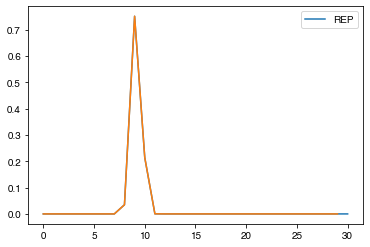

In [179]:
plt.plot(rep[0, 3, 10, 0], label='REP')
plt.plot(rep1[0, 3, 10, 0])
plt.legend()

(1, 12, 12, 12, 30)

### Data

Clear all caches.

In [32]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [189]:
%%time
z, r, e, elems, n = load_qm_17('datasets/benzene2017_dft.npz', n=627983)

CPU times: user 1.02 s, sys: 189 ms, total: 1.21 s
Wall time: 1.37 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [34]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [35]:
%%time
dsi = dataset_info(z, r, e, basis=None, verbose=True)

627983 finite systems (molecules)
elements: H C (2)
max #els/system: 2;  max #el/system: 6;  max #atoms/system: 12
min dist: 0.97;  max dist: 5.28;  1/min dist: 1.03;  1/max dist: 0.19
CPU times: user 2min 22s, sys: 835 ms, total: 2min 23s
Wall time: 2min 23s


### MBTR (MD variant)

#### Linear kernel

In [68]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-12.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 18, #evals = 23, done = True
best solution: f(-4.5, -2.0, -17.0) = 0.0469
var = 1, update = False
converged vars: T  T  T , directions: -1 +1 +1

n       = 2000
RMSE    = 0.046
MAE     = 0.034
R^2     = 0.999623
maxAE   = 0.340
RMSE/a  = 0.004
MAE/a   = 0.003
maxAE/a = 0.028

CPU times: user 43min 14s, sys: 1min 3s, total: 44min 17s
Wall time: 8min 13s


#### Gaussian kernel

In [36]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(2**-4.0, 2**-1.5, 2**2.5, 2**-20.0)

print(pretty_print_loss(f.loss.loss, digits=3))

n       = 2000
RMSE    = 0.036
MAE     = 0.026
R^2     = 0.999769
maxAE   = 0.198
RMSE/a  = 0.003
MAE/a   = 0.002
maxAE/a = 0.016

CPU times: user 1min 23s, sys: 13.7 s, total: 1min 36s
Wall time: 52.4 s


In [40]:
f.kernelf.__dict__

{'f': <function qmmlpack.kernels_gaussian.kernel_gaussian(x, z=None, theta=None, diagonal=False, distance=False)>,
 'max_entries': 35,
 'cache': {b'\x14b\xfbJ)\x03\xc5\xa6\xe8\x19\x8d\x0b\xc3I\x87<': [0,
   array([[1.        , 0.99893582, 0.9989564 , ..., 0.9943778 , 0.99227957, 0.99385754],
          [0.99893582, 1.        , 0.99784575, ..., 0.99463427, 0.99229102, 0.99481257],
          [0.9989564 , 0.99784575, 1.        , ..., 0.99501046, 0.99421041, 0.99412325],
          ...,
          [0.9943778 , 0.99463427, 0.99501046, ..., 1.        , 0.98937236, 0.99304656],
          [0.99227957, 0.99229102, 0.99421041, ..., 0.98937236, 1.        , 0.98959276],
          [0.99385754, 0.99481257, 0.99412325, ..., 0.99304656, 0.98959276, 1.        ]])],
  b'5\xb9\x10\x9a\xd4\x00\x92 \x12\xb0ST/*4\x06': [1,
   array([[0.99789802, 0.99820997, 0.99848039, ..., 0.99476154, 0.99327181, 0.99537457],
          [0.99871053, 0.99866122, 0.99846683, ..., 0.99531825, 0.99398631, 0.99351378],
          [0